# Environment Setup

In [1]:
# Base imports
import time
import random
import sys
import tqdm
import os
from multiprocessing import Pool, cpu_count
import concurrent
from pathlib import Path
import pickle as pk
from tqdm.contrib.concurrent import process_map
import requests
import copy
import math
import traceback
import networkx as nx 

# Data processing/pre-processing/comparison imports
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind, binom_test, ks_2samp
import statistics
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, wasserstein_distance
from scipy import interpolate, optimize 
import scipy.stats as stats

# Torch/Geneformer imports
import torch
from geneformer import TranscriptomeTokenizer
from transformers import BertForSequenceClassification, BertForTokenClassification, BertModel
from pathlib import Path
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda:0')

# Sets random seed
random.seed(42)

/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Network Functions

In [2]:
from base_utils.network_utils import *
from base_utils.string_db import *

# Attention Extraction Functions

In [3]:
from base_utils.attention_utils import *

# Edge Prediction AUC + Distributions

In [4]:
def F1_graph_attention(PPI, gene_attentions, 
                       graph = True, 
                       keyword = None,
                       save = False, 
                       epsilon = 10e-5):
        
    # Obtains attentions
    real_attentions, total_attentions = process_edges(PPI, gene_attentions, 
                                                      min_threshold = epsilon)
    fake_attentions = generate_fake_attentions(PPI, len(real_attentions), gene_attentions, 
                                               min_threshold = epsilon,)
    

    # Generates 'real' and 'fake' labels for attentions
    fake_labels = [0 for _ in range(len(fake_attentions))] 
    background_fake_labels = [0 for _ in range(len(total_attentions))]
    real_labels = [1 for _ in range(len(real_attentions))]
    
    # Combines labels
    fake_labels = fake_labels + real_labels
    background_labels = background_fake_labels + real_labels
    fake_attentions = fake_attentions + real_attentions
    background_attentions = total_attentions + real_attentions
    
    # Compute ROC and AUC
    PPI_fpr, PPI_tpr, _ = roc_curve(background_labels, background_attentions)
    PPI_auc = auc(PPI_fpr, PPI_tpr)
    
    if save == True:
        data = {
            'PPI-background FPR': PPI_fpr,
            'PPI-background TPR': PPI_tpr,
        }
        data = pd.DataFrame.from_dict(data, orient = 'index')
        data = data.transpose()
        data.to_csv(f'AUC_scores_{keyword}.csv', index = False)

    # Plots AUC curve
    plt.figure()
    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0, 1.05])
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--',)
    plt.plot(PPI_fpr, PPI_tpr, color = 'green', label = f'PPI Edge Discovery \n (AUC: {round(PPI_auc, 4)})')
    plt.legend(loc='lower right', fontsize = 12)#, bbox_to_anchor=(0, 0.2), ncol=1)
    plt.tight_layout()
    plt.show()

# Plots attention distributions for background or a PPI/disease if specified
def plot_distributions(PPI, attention_dict, disease = None, graph = True, keyword = None,
                       epsilon = 10e-5, ratio_comparisons = False,
                       save = True, cdf = False):    

    if disease == None:
        # Parallel processing to extract attentions
        real_attentions, total_attentions = process_edges(PPI, attention_dict, min_threshold = epsilon)
        PPI_fake = generate_fake_attentions(PPI, len(PPI), attention_dict, respect_PPI = True, min_threshold = epsilon)

        # Saves data
        if save == True:
            save_dictionary = {
                f'total_attentions': random.sample(total_attentions, 10000),
                f'PPI_attentions': random.sample(real_attentions, 1000),
                f'PPI_fake_attentions': random.sample(PPI_fake, 1000),
            }
            save_dataframe = pd.DataFrame.from_dict(save_dictionary, orient = 'index').T
            save_dataframe.to_csv(f'PPIAttentionDist_{keyword}.csv')
    
        plt.figure()
    
        if cdf == True:
            sns.ecdfplot(total_attentions, color='red', label=f'Background')# (n={len(total_attentions)})')
            sns.ecdfplot(real_attentions, color='green', label=f'PPI')# (n={len(real_attentions)})')
            sns.ecdfplot(PPI_fake, color='black', label=f'PPI Fake')
            plt.ylabel('Cumulative Probability')
        else:
            sns.kdeplot(total_attentions, color='red', label='Background', bw_adjust=0.1, log_scale=True)
            sns.kdeplot(real_attentions, color='green', label='PPI', bw_adjust=0.1, log_scale=True)
            sns.kdeplot(PPI_fake, color='black', label='PPI Fake', bw_adjust=0.1, log_scale=True)
            
            # Adjusting x-axis to show original scale values
            def log_tick_formatter(val, pos=None):
                return f"{np.exp(val):.2g}"  # This formats the log-transformed labels back to the original scale
    
            # Set x-axis to logarithmic scale
            plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
            plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10))
            plt.ylabel('Probability')
            
        plt.xlabel('Attention Weights')
        plt.legend(loc='upper left')
        plt.xscale('log')
        plt.xlim(0, 0.1)
        plt.tight_layout()
        plt.show()
    else:

        # Instantiates disease LCC
        disease_genes = isolate_disease_genes(disease)
        disease_LCC = LCC_genes(PPI, disease_genes, 
                                subgraph = True)
        LCC = map_attention(disease_LCC, 
                                      attention_dict, 
                                      LCC = True, 
                                      min_threshold = epsilon)

        # Instantiates degree-distributed fake PPI weights
        PPI_fake = generate_fake_attentions(PPI, len(PPI), attention_dict, respect_PPI = True, min_threshold = epsilon)
        
        # Instantiates fully connected disease LCC
        LCC_connected = nx.complete_graph(disease_genes,)
        LCC_connected = map_attention(LCC_connected, attention_dict, LCC = True, min_threshold = epsilon)

        # Parallel processing to extract attentions
        real_attentions, total_attentions = process_edges(LCC, attention_dict, min_threshold = epsilon)
        connected_attentions, _ = process_edges(LCC_connected, attention_dict, min_threshold = epsilon)
        PPI_attentions, _ = process_edges(PPI, attention_dict, min_threshold = epsilon)

        # Saves data
        if save == True:
            save_dictionary = {
                f'LCC_attentions': real_attentions,
                f'total_attentions': random.sample(total_attentions, 10000),
                f'PPI_attentions': random.sample(PPI_attentions, 1000),
                f'connected_attentions': connected_attentions,
                f'degree_distributed_PPI_background': random.sample(PPI_fake, 1000),
            }
            save_dataframe = pd.DataFrame.from_dict(save_dictionary, orient = 'index').T
            save_dataframe.to_csv(f'LCC_PPI_AttentionDist_{keyword}.csv')

        # Plot CDF
        plt.figure()
        
        if cdf == True:
            sns.ecdfplot(total_attentions, color='red', label=f'Background')# (n={len(total_attentions)})')
            sns.ecdfplot(real_attentions, color='blue', label=f'LCC')# (n={len(real_attentions)})')
            sns.ecdfplot(PPI_attentions, color='green', label=f'PPI')# (n={len(PPI_attentions)})')
            sns.ecdfplot(connected_attentions, color='orange', label=f'GDA Disease')# (n={len(connected_attentions)})')
            sns.ecdfplot(PPI_fake, color='black', label=f'PPI Fake')
            plt.ylabel('Cumulative Probability')
        else:
            sns.kdeplot(total_attentions, color='red', label=f'Background', bw_adjust=0.25, log_scale=True)# (n={len(total_attentions)})')
            sns.kdeplot(real_attentions, color='blue', label=f'LCC', bw_adjust=0.25, log_scale=True)# (n={len(real_attentions)})')
            sns.kdeplot(PPI_attentions, color='green', label=f'PPI', bw_adjust=0.25, log_scale=True)# (n={len(PPI_attentions)})')
            sns.kdeplot(connected_attentions, color='orange', label=f'GDA Disease', bw_adjust=0.25, log_scale=True)# (n={len(connected_attentions)})')
            sns.kdeplot(PPI_fake, color='black', label=f'PPI Fake', bw_adjust=0.25, log_scale=True)
            plt.ylabel('Probability')

            # Adjusting x-axis to show original scale values
            def log_tick_formatter(val, pos=None):
                return f"{np.exp(val):.2g}"  # This formats the log-transformed labels back to the original scale

            # Set x-axis to logarithmic scale
            plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
            plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10))

            plt.xlabel('Attention Weights')
            plt.ylabel('Cumulative Probability')
            plt.legend(loc='upper left')
            plt.xscale('log')
            plt.tight_layout()
            plt.show()
        

# Config

In [5]:
layer_index = 4 # Layer where attention extraction will be performed from
mean = False # Uses maximum aggregation instead of mean aggregation
samples = 100 # Number of samples to aggregate

dataset_location = Path('/work/ccnr/GeneFormer/GeneFormer_repo/Genecorpus-30M/example_input_files/cell_classification/cell_type_annotation/cell_type_train_data.dataset/')
#dataset_location = Path("Genecorpus-30M/genecorpus_30M_2048.dataset") 
model_location = Path(".")
filter_label = None
save_threshold = None

# Pre-trained Attention Extraction

In [6]:
# Creates PPI
PPI = instantiate_PPI()

# Obtains aggregate attentions from saved Geneformer model
gene_attentions = extract_attention(model_location = model_location,
                                    data = dataset_location,
                                    mean = mean,
                                    layer_index = layer_index,
                                    samples = samples,
                                    filter_label = filter_label,)

Some weights of BertModel were not initialized from the model checkpoint at . and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Passing data through model: 100%|██████████| 13/13 [02:26<00:00, 11.28s/it]


9076 total source genes represented in the final dataset


# Base Analysis

Generating Fake Edges: 100%|██████████| 74373/74373 [08:54<00:00, 139.11it/s]


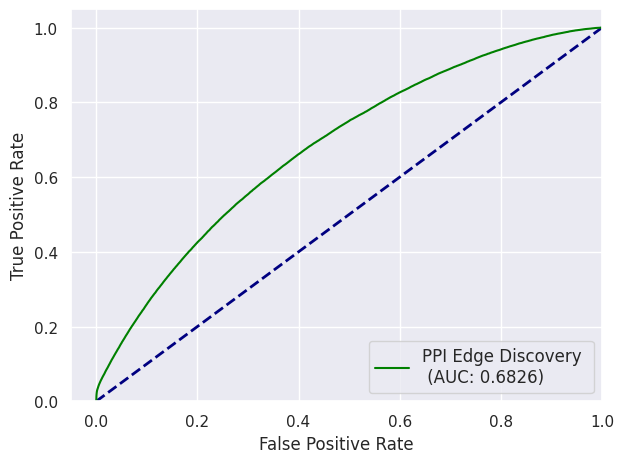

Generating Fake Edges: 100%|██████████| 18130/18130 [02:04<00:00, 145.69it/s]
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_5108/1945610921.py:94: UserW

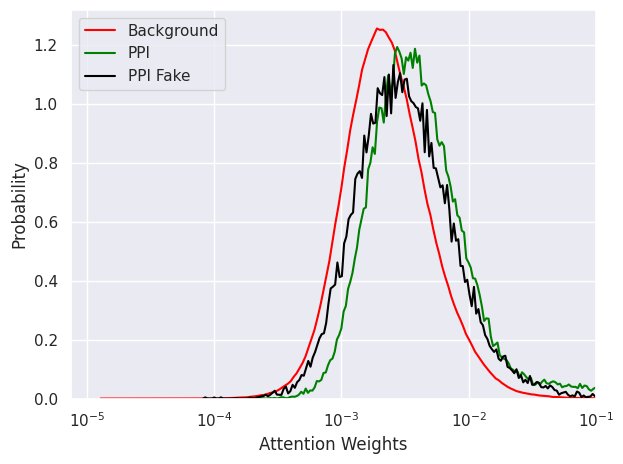

In [7]:
# Maps attention weights to PPI
PPI = map_attention(PPI, gene_attentions, save = False)

# Tries ranked edge prediction
F1_graph_attention(PPI, gene_attentions = gene_attentions, epsilon = None)

# Plots Distributions
plot_distributions(PPI, attention_dict = gene_attentions, cdf = False, epsilon = 10e-8)    

# Disease Comparisons

Some weights of BertModel were not initialized from the model checkpoint at . and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Passing data through model: 100%|██████████| 13/13 [02:05<00:00,  9.62s/it]


6589 total source genes represented in the final dataset


Processing Edges: 100%|██████████| 48559/48559 [00:00<00:00, 545558.59it/s]
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib

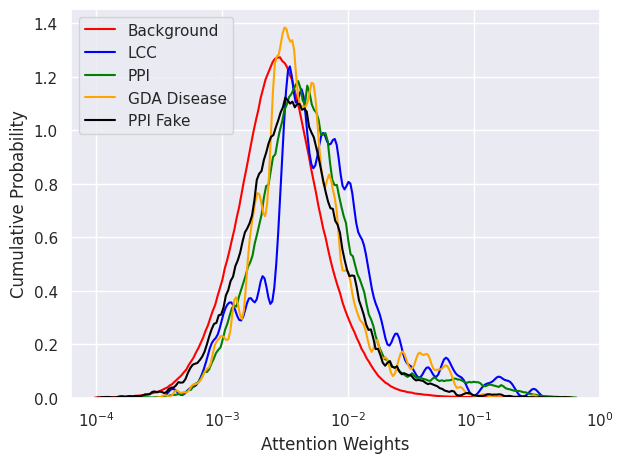

In [8]:
# Obtains PPI
PPI = instantiate_PPI()

# Obtains aggregate attentions from saved Geneformer model
arth_attentions = extract_attention(model_location = model_location,
                                    data = dataset_location,
                                    mean = mean,
                                    layer_index = layer_index,
                                    samples = samples,
                                    filter_label = ('organ_major', 'immune'))
disease = 'arthritis rheumatoid'

# Maps attention weights to PPI
PPI = map_attention(PPI, arth_attentions, save = False)

# Distributions for arthritis
plot_distributions(PPI, attention_dict = arth_attentions, cdf = False, disease = disease)

Processing Edges: 100%|██████████| 48559/48559 [00:00<00:00, 485223.74it/s]
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib

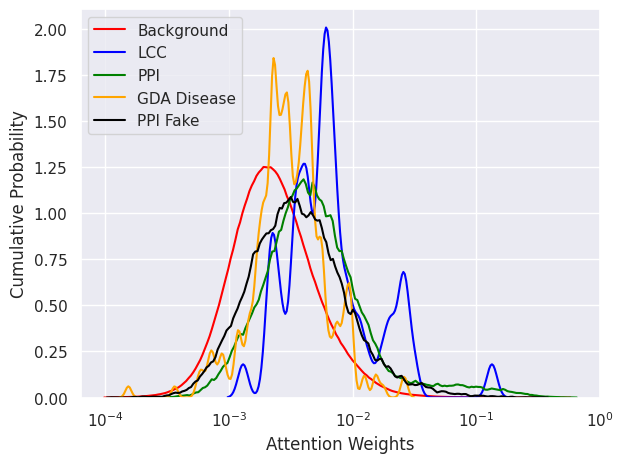

In [9]:
disease = 'cardiomyopathy hypertrophic'

# Distributions for cardiomyopathy
plot_distributions(PPI, attention_dict = gene_attentions, cdf = False, disease = disease)

Processing Edges: 100%|██████████| 48559/48559 [00:00<00:00, 513438.27it/s]
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib

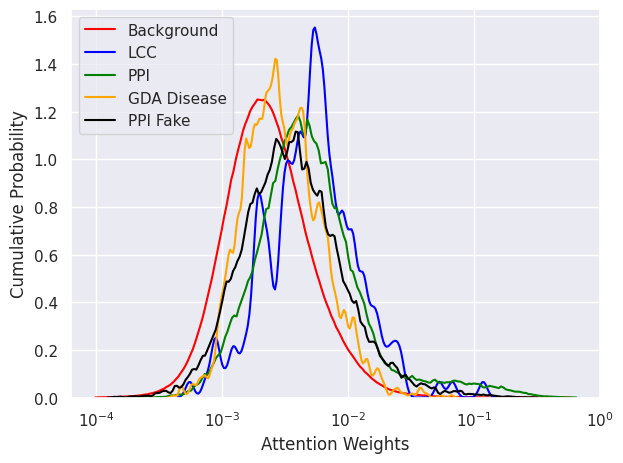

In [10]:
disease = 'adenocarcinoma'

# Distributions for adenocarcinoma
plot_distributions(PPI, attention_dict = gene_attentions, cdf = False, disease = disease)

Processing Edges: 100%|██████████| 48559/48559 [00:00<00:00, 501327.24it/s]
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/defrondeville.c/miniconda3/envs/LLM/lib

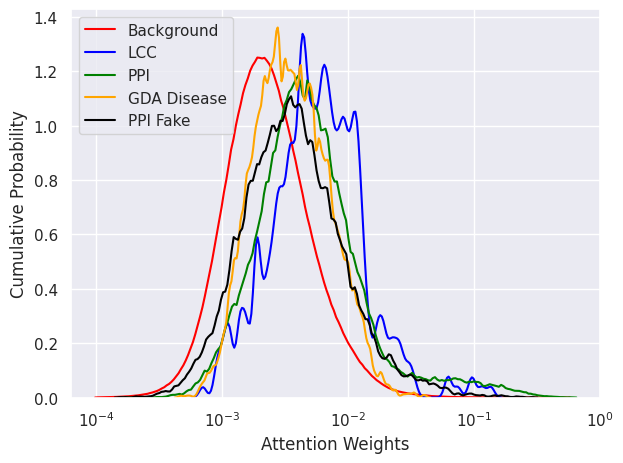

In [11]:
disease = 'covid'

# Distributions for covid
plot_distributions(PPI, attention_dict = gene_attentions, cdf = False, disease = disease)

# PPI Edge Discovery + String

Finding true hits: 100001it [00:00, 607920.28it/s]                           
/tmp/ipykernel_5108/3040086813.py:64: RuntimeWarning: invalid value encountered in divide
  plt.plot(random_xvals, np.array(random_discovery) / np.array(random_xvals) , label = 'Random Sampling', color = 'blue')
/tmp/ipykernel_5108/3040086813.py:65: RuntimeWarning: invalid value encountered in divide
  plt.plot(weighted_xvals, np.array(weighted_discovery) / np.array(weighted_xvals), label = 'Ranked Sampling', color = 'red')


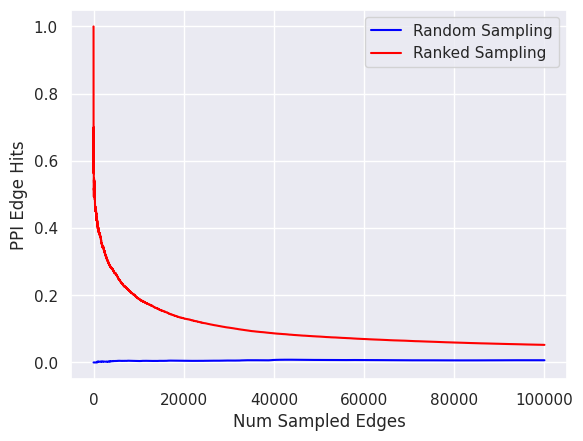

Analyzing Interactions: 100%|██████████| 10000/10000 [12:10<00:00, 13.68it/s]
/tmp/ipykernel_5108/3040086813.py:26: RuntimeWarning: divide by zero encountered in divide
  plt.plot(ranked_xvals,  np.array(ranked_interactions) / np.array(ranked_xvals), label = 'Ranked Attention STRING Discovery', color = 'red',)
/tmp/ipykernel_5108/3040086813.py:27: RuntimeWarning: invalid value encountered in divide
  plt.plot(random_xvals, np.array(random_interactions) / np.array(random_xvals), label = 'Random Attention STRING Discovery', color = 'blue')


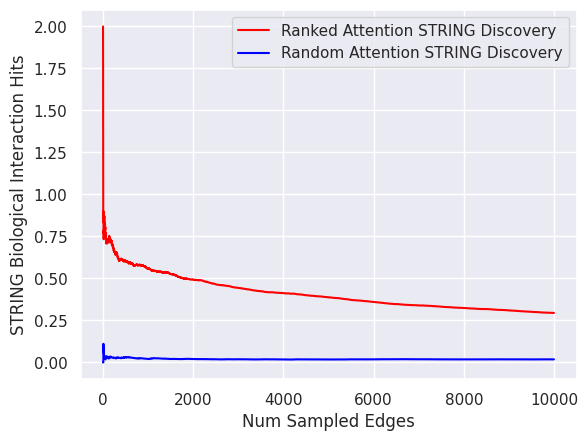

In [12]:
# Function for ranking STRING interactions
def true_interactions(gene_attentions, max_pairs = 10_000):
    
     # Flattens attention weight dictionary
    flattened_dict = [(source, target, value)
                for source, inner_dict in gene_attentions.items()
                for target, value in inner_dict.items() if not isinstance(value, list)]

    random_gene_pairs = [i[:2] for i in flattened_dict]
    random.shuffle(random_gene_pairs)

    # Ranks values by attention weight
    ranked_pairs = sorted(flattened_dict, reverse = True, key = lambda x: x[2])
    ranked_pairs = [i[:2] for i in ranked_pairs]

    # Subsamples pairs
    ranked_pairs = ranked_pairs[:max_pairs] #random.sample(ranked_pairs, max_pairs)
    random_gene_pairs = random_gene_pairs[:max_pairs]

    # Analyzes pairs
    ranked_interactions = analyze_interactions(ranked_pairs)
    random_interactions = analyze_interactions(random_gene_pairs)    
    # Creates CDF
    plt.figure()
    ranked_xvals, random_xvals = [i for i in range(len(ranked_interactions))], [i for i in range(len(ranked_interactions))]
    plt.plot(ranked_xvals,  np.array(ranked_interactions) / np.array(ranked_xvals), label = 'Ranked Attention STRING Discovery', color = 'red',)
    plt.plot(random_xvals, np.array(random_interactions) / np.array(random_xvals), label = 'Random Attention STRING Discovery', color = 'blue')
    plt.xlabel('Num Sampled Edges')
    plt.ylabel('STRING Biological Interaction Hits')
    plt.legend()
    plt.show()
    #ranked_xvals = 

def PPI_edge_discovery(PPI, gene_attentions, num_attentions = 100_000):

    # Flattens dictionary 
    flattened_dict = [(source, target, value)
                for source, inner_dict in gene_attentions.items()
                for target, value in inner_dict.items() if not isinstance(value, list)]
    
    # Sorts dictionary by attention weights
    sorted_weights = sorted(flattened_dict, key = lambda x: x[2], reverse = True)

    weighted_discovery, random_discovery = [], []
    weighted_counter, random_counter = 0, 0
    for num, ((source, target, value), (ranked_source, ranked_target, ranked_value)) in tqdm.tqdm(enumerate(zip(flattened_dict, sorted_weights)), total = num_attentions, desc = 'Finding true hits'):
        if unweighted_PPI.has_edge(source, target):
            random_counter += 1
    
        if unweighted_PPI.has_edge(ranked_source, ranked_target):
            weighted_counter += 1
            
        random_discovery.append(random_counter)
        weighted_discovery.append(weighted_counter)
        if num > num_attentions:
            break

    # Plots ranked and weighted values
    plt.figure()
    plt.xlabel('Num Sampled Edges')
    plt.ylabel('PPI Edge Hits')
    random_xvals = [i for i in range(len(random_discovery))]
    weighted_xvals = [i for i in range(len(weighted_discovery))]
    plt.plot(random_xvals, np.array(random_discovery) / np.array(random_xvals) , label = 'Random Sampling', color = 'blue')
    plt.plot(weighted_xvals, np.array(weighted_discovery) / np.array(weighted_xvals), label = 'Ranked Sampling', color = 'red')
    plt.legend(loc = 'upper right')
    plt.show()

unweighted_PPI = instantiate_PPI()
PPI_edge_discovery(unweighted_PPI, gene_attentions = gene_attentions)
true_interactions(gene_attentions = gene_attentions)